# Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# Constants

In [2]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read Data

In [17]:
dataset_path = Path().resolve() / "wine"
dataset_path
df_red = pd.read_csv(dataset_path / "winequality-red.csv", sep=';')
df_white = pd.read_csv(dataset_path / "winequality-white.csv", sep=';')
df_red['color'] = 1
df_white['color'] = 0
df = pd.concat([df_red, df_white], ignore_index=True)

In [19]:
X = df.drop('quality', axis=1).values
# Remap quality labels from [3, 4, 5, 6, 7, 8, 9] to [0, 1, 2, 3, 4, 5, 6]
y = df['quality'].values - 3

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42,
)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long).squeeze()

In [23]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [24]:
n_features = X_train.shape[1]
n_classes = len(np.unique(y))

# Prepare pipeline

In [26]:
class MLP(nn.Module):
    def __init__(self, hidden_layers : list[int] = [64, 32], activation = nn.ReLU):
        super().__init__()
        layers = []
        in_dim = n_features
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation())
            in_dim = h
        layers.append(nn.Linear(in_dim, n_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [27]:
def train_model(model: nn.Module, optimizer: torch.optim, epochs: int, lr: float):
    criterion = nn.CrossEntropyLoss()
    opt = optimizer(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            logits = model(xb)
            loss = criterion(logits, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()*xb.size(0)
        avg_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        xb_val,yb_val = next(iter(val_loader))
        with torch.no_grad():
            logits = model(xb_val)
            val_loss = criterion(logits, yb_val).item()
            preds = torch.argmax(logits, dim=1)
            acc = (preds == yb_val).float().mean().item()

        if ep % 10 == 0 or ep == epochs-1:
            print(f"Epoch {ep:02d} | train_loss={avg_loss:.4f} val_loss={val_loss:.4f} acc={acc:.4f}")

    return model

In [28]:
configs = [
    {
        "hidden" : [64, 32],
        "act"    : nn.ReLU,
        "opt"    : torch.optim.AdamW,
        "lr"     : 1e-3,
    },
    {
        "hidden" : [128, 64, 32],
        "act"    : nn.ReLU,
        "opt"    : torch.optim.Adam,
        "lr"     : 5e-4,
    },
    {
        "hidden" : [128,64],
        "act"    : nn.Tanh,
        "opt"    : torch.optim.AdamW,
        "lr"     : 1e-3,
    },
]

best_model = None
best_acc = 0

for i, cfg in enumerate(configs):
    print("Config:", cfg)
    model = MLP(hidden_layers=cfg["hidden"], activation=cfg["act"])
    trained_model = train_model(model, cfg["opt"], epochs=EPOCHS, lr=cfg["lr"])

    trained_model.eval()
    xb_val, yb_val = next(iter(val_loader))
    with torch.no_grad():
        logits = trained_model(xb_val)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == yb_val).float().mean().item()

    print(f"Val accuracy = {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_model = trained_model

Config: {'hidden': [64, 32], 'act': <class 'torch.nn.modules.activation.ReLU'>, 'opt': <class 'torch.optim.adamw.AdamW'>, 'lr': 0.001}


IndexError: Target 7 is out of bounds.


Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



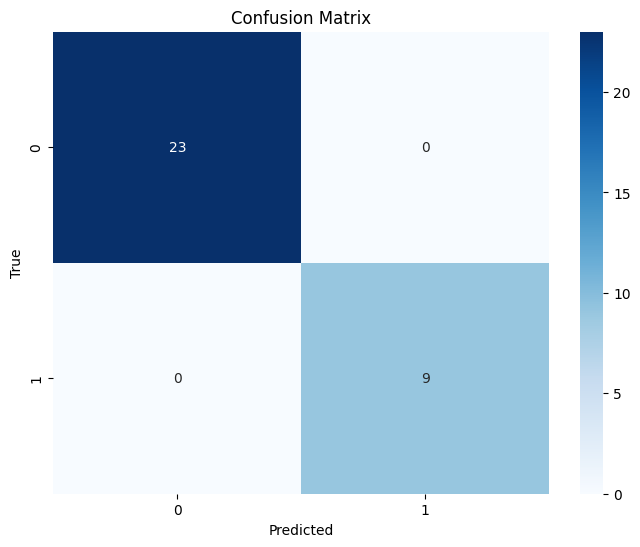

In [14]:
if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        xb, yb = next(iter(val_loader))
        preds = torch.argmax(best_model(xb), dim=1)

    print("\nClassification report:")
    print(classification_report(yb.numpy(), preds.numpy()))

    cm = confusion_matrix(yb.numpy(), preds.numpy())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("No best model found.")